In [1]:
import numpy as np
import pickle as pkl
import torch
import torch.nn as nn
import os
import torch.optim as optim
from probe_experiment import ProbeExperiment
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from math import ceil

In [2]:
with open('data/filtered_annotations.pkl', 'rb') as file:
    annotations = pkl.load(file)
annotations.sort(key = lambda ant : ant['f_name'])

train_ants = annotations[:int(len(annotations)*0.8)]
test_ants = annotations[int(len(annotations)*0.8):]

keywords = ['territory', 'cut', 'sente', 'shape', 'moyo',
            'ko', 'invasion', 'influence', 'wall', 'eye']

In [3]:
from go_model import GoModel
go_model = GoModel(None)
checkpoint = torch.load('model_ckpt.pth.tar', map_location=torch.device('cuda'))
state_dict = checkpoint['state_dict']
state_dict = {key[7:]:state_dict[key] for key in state_dict} #remove 'module.' prefix
go_model.load_state_dict(state_dict)

<All keys matched successfully>

In [4]:
def cut_model(model, cut_at_layer):
    class CutModel(nn.Module):
        def __init__(self, model, cut):
            super(CutModel, self).__init__()
            self.convs = model.convs[:cut]
            self.nonlinear = model.nonlinear
            self.cut = cut
        
        def forward(self, x):
            for i in range(self.cut):
                x = self.convs[i](x)
                x = self.nonlinear(x)
            return nn.Flatten()(x)
    return CutModel(model, cut_at_layer)

models = [cut_model(go_model, i).cuda() for i in range(8)]

In [5]:
layer_n_channels = [8, 64, 64, 64, 48, 48, 32, 32]
layer_dims = [n*19*19 for n in layer_n_channels]
probe_models = [nn.Linear(dim, len(keywords)).cuda() for dim in layer_dims]

In [6]:
from probe_dataset import *
train_dataset = SPBoWDataset(train_ants, keywords)
test_dataset = SPBoWDataset(test_ants, keywords)
train_dataset = load_to_memory(train_dataset)
test_dataset = load_to_memory(test_dataset)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 46813/46813 [01:03<00:00, 733.90it/s]


In [7]:
exp = ProbeExperiment(train_dataset, test_dataset, keywords, None)

In [8]:
preds = []

for i in range(8):
    feat_model = models[i]
    probe_model = probe_models[i]
    
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(probe_model.parameters())
    
    exp.run('depth%d_probe'%i, feat_model, probe_model, criterion, optimizer, batch_size=64, num_epochs=2)
    preds_, labels = exp.test_inference(feat_model, probe_model)
    preds.append(preds_)

epoch 0 loss 0.160182
epoch 1 loss 0.162811
epoch 0 loss 0.174018
epoch 1 loss 0.181932
epoch 0 loss 0.174099
epoch 1 loss 0.178929
epoch 0 loss 0.199332
epoch 1 loss 0.209298
epoch 0 loss 0.190238
epoch 1 loss 0.194329
epoch 0 loss 0.169713
epoch 1 loss 0.176324
epoch 0 loss 0.159920
epoch 1 loss 0.161689
epoch 0 loss 0.156894
epoch 1 loss 0.157781


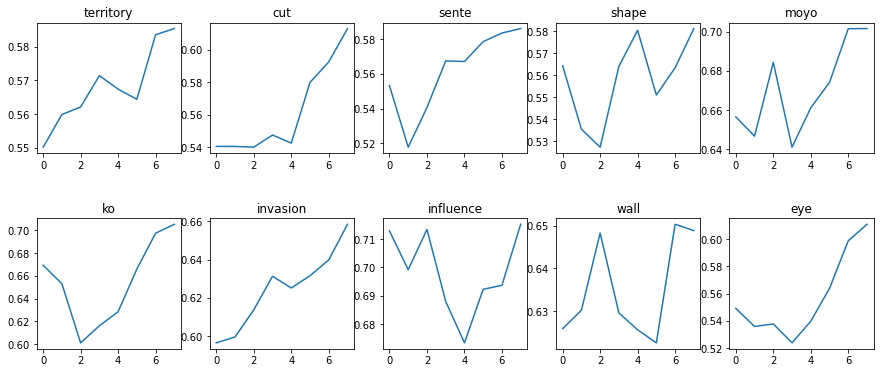

In [9]:
cols = 5
rows = ceil(len(keywords)/cols)
plt.rcParams['figure.figsize'] = (3*cols, 3*rows)
fig, axs = plt.subplots(rows, cols)
fig.subplots_adjust(hspace=0.5)

for kw in range(len(keywords)):
    aucs = []
    for depth in range(8):
        kw_preds = preds[depth][:, kw]
        kw_labels = labels[:, kw]
        auc = roc_auc_score(kw_labels, kw_preds)
        aucs.append(auc)
    axs[kw//cols][kw%cols].plot(aucs)
    axs[kw//cols][kw%cols].set_title(keywords[kw])
    

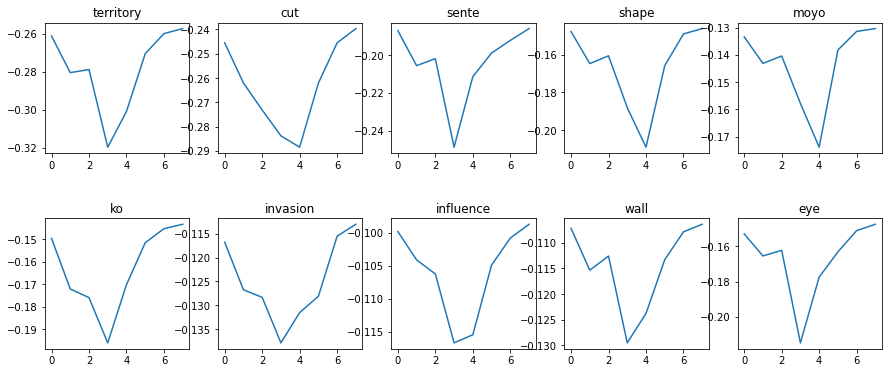

In [10]:
cols = 5
rows = ceil(len(keywords)/cols)
plt.rcParams['figure.figsize'] = (3*cols, 3*rows)
fig, axs = plt.subplots(rows, cols)
fig.subplots_adjust(hspace=0.5)

for kw in range(len(keywords)):
    losses = []
    for depth in range(8):
        kw_preds = preds[depth][:, kw]
        kw_labels = labels[:, kw]
        loss = nn.BCEWithLogitsLoss()(torch.from_numpy(kw_preds), torch.from_numpy(kw_labels))
        losses.append(-loss)
    axs[kw//cols][kw%cols].plot(losses)
    axs[kw//cols][kw%cols].set_title(keywords[kw])